In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:44541")
client

<Client: 'tcp://127.0.0.1:44541' processes=8 threads=32, memory=125.87 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import gsw
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
import MITgcmutils as mitutils
from xmitgcm import open_mdsdataset
# from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
spec = '/tank/spectre/tuchida/NA-wavelets/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 5
sreg = ['A','B','C','D','E','F']

xo = 50e3

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

In [6]:
ntheta = 36
ss = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' 
                  % reg).scale/xo
ss

<xarray.DataArray 'scale' (scale: 49)>
array([10.7548446 , 10.48916347, 10.22348234,  9.95780121,  9.69212008,
        9.42643895,  9.16075782,  8.89507669,  8.62939556,  8.36371443,
        8.0980333 ,  7.83235217,  7.56667104,  7.30098991,  7.03530878,
        6.76962765,  6.50394652,  6.23826539,  5.97258426,  5.70690313,
        5.441222  ,  5.17554087,  4.90985974,  4.64417861,  4.37849748,
        4.11281635,  3.84713522,  3.58145408,  3.31577295,  3.05009182,
        2.78441069,  2.51872956,  2.25304843,  1.9873673 ,  1.72168617,
        1.45600504,  1.19032391,  0.96899592,  0.85475004,  0.76558849,
        0.69338215,  0.63275035,  0.5818319 ,  0.53880548,  0.50168688,
        0.46930024,  0.44102169,  0.41591375,  0.39328052])
Coordinates:
  * scale    (scale) float64 5.377e+05 5.245e+05 ... 2.08e+04 1.966e+04

In [7]:
# iiter = 1419120
# iiter = 1421280
iiter = 1423440
Zs = [18]

In [21]:
diags = np.concatenate((np.arange(-1,0),np.arange(1,2)))
# diags = np.arange(-1,2)

for ng in diags[:]:
    nx = ng
    ny = ng
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                               YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                               XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                               XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    
    dsm = xr.open_zarr(op.join(spec,'Snaps_Tot-Adv_EnsMean/%010d.zarr' % iiter)
                  ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                        YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                        XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                        XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                       ).chunk({'Z':1})

    dsUmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                            grid_dir=gdir,
                            prefix=['diagUm'], delta_t=2e2,
                            iters=iiter, 
                            ignore_unknown_vars=True
                           ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                 YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                 XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                 XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    if len(dsb.XG) > len(dsb.XC):
        dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
        dsb = dsb.isel(XC=slice(None,-1))
    if len(dsUmb.XG) > len(dsb.XC):
        dsUmb = dsUmb.isel(XG=slice(None,-1))
    elif len(dsUmb.XG) < len(dsb.XC):
        dsUmb = dsUmb.isel(XC=slice(None,-1))

    dsVmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                            grid_dir=gdir,
                            prefix=['diagVm'], delta_t=2e2,
                            iters=iiter, 
                            ignore_unknown_vars=True
                           ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                 YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                 XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                 XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    # dsUmextb = xr.open_zarr(op.join(savedir,'SnapsUm-ext_EnsMean_%010d.zarr' % iiter)
    #                        ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
    #                              XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
    #                             ).isel(XG=slice(None,116))
    # dsVmextb = xr.open_zarr(op.join(savedir,'SnapsVm-ext_EnsMean_%010d.zarr' % iiter)
    #                        ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
    #                              XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
    #                             )
    
    grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #         'Y': {'center': 'YC', 'left': 'YG'},
            #         'X': {'center': 'XC', 'left': 'XG'}}
           )
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            dsUm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                   grid_dir=gdir,
                                   prefix=['diagUm'], delta_t=2e2,
                                   iters=iiter, 
                                   ignore_unknown_vars=True
                                  ).reset_coords(drop=True).drop_dims(['YG','XC','Zl',
                                                                       'Zu','Zp1']
                                                                     ).sel(
                                                                   YC=slice(ys[reg]-5+ny/12,
                                                                            ys[reg]+5+ny/12),
                                                                   XG=slice(xs[reg]-5+nx/12,
                                                                            xs[reg]+5+nx/12)
                                                                      ).isel(time=0)
            dsVm = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                   grid_dir=gdir,
                                   prefix=['diagVm'], delta_t=2e2,
                                   iters=iiter, 
                                   ignore_unknown_vars=True
                                  ).reset_coords(drop=True).drop_dims(['YC','XG','Zl',
                                                                       'Zu','Zp1']
                                                                     ).sel(
                                                                   YG=slice(ys[reg]-5+ny/12,
                                                                            ys[reg]+5+ny/12),
                                                                   XC=slice(xs[reg]-5+nx/12,
                                                                            xs[reg]+5+nx/12)
                                                                      ).isel(time=0)
            # ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
            #                                  % (nmemb)), 
            #                          grid_dir=gdir,
            #                          prefix=['diagUm'], delta_t=2e2,
            #                          iters=iiter, 
            #                          ignore_unknown_vars=True
            #                         ).reset_coords(drop=True).drop_dims(['YG','XC','Zl',
            #                                                              'Zu','Zp1']
            #                                                            ).chunk({'YC':ychunk,
            #                                                                     'XG':xchunk,
            #                                                                     'Z':10}
            #                                                                   ).isel(time=0)
            # Um_dEdx = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
            #                                               % (nmemb)), itrs=iiter, 
            #                                       rec=3,    # U from surface pressure
            #                      # usememmap=True
            #                                      ),
            #                        dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
            #                       ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                             XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
            #                            )
            # Um_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagUm' 
            #                                               % (nmemb)), itrs=iiter, 
            #                                       rec=5,    # Vertical dissipation
            #                      # usememmap=True
            #                                      ),
            #                        dims=ds_raw.TOTUTEND.dims, coords=ds_raw.TOTUTEND.coords
            #                       ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                             XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
            #                            )
            # ds_raw.close()
            # ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
            #                                  % (nmemb)), 
            #                          grid_dir=gdir,
            #                          prefix=['diagVm'], delta_t=2e2,
            #                          iters=iiter, 
            #                          ignore_unknown_vars=True
            #                         ).reset_coords(drop=True).drop_dims(['YC','XG','Zl',
            #                                                              'Zu','Zp1']
            #                                                            ).chunk({'YG':ychunk,
            #                                                                     'XC':xchunk,
            #                                                                     'Z':10}
            #                                                                   ).isel(time=0)
            # Vm_dEdy = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
            #                                               % (nmemb)), itrs=iiter, 
            #                                       rec=3,    # U from surface pressure
            #                      # usememmap=True
            #                                      ),
            #                        dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
            #                       ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                             XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
            #                            )
            # Vm_Disv = xr.DataArray(mitutils.rdmds(op.join(ddir,'memb%03d/run1967/ocn/diagVm' 
            #                                               % (nmemb)), itrs=iiter, 
            #                                       rec=5,    # Vertical dissipation
            #                      # usememmap=True
            #                                      ),
            #                        dims=ds_raw.TOTVTEND.dims, coords=ds_raw.TOTVTEND.coords
            #                       ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                             XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
            #                            )
            # ds_raw.close()
        else:
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            ds = xr.concat([ds, ds1], dim='nmemb')
            ds1.close()
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagUm'], delta_t=2e2,
                                  iters=iiter, 
                                  ignore_unknown_vars=True
                                 ).reset_coords(drop=True).drop_dims(['Zl','Zu','Zp1']
                                                                    ).sel(
                                                                  YC=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  YG=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  XC=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12),
                                                                  XG=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12)
                                                                         ).isel(time=0)
        
            dsUm = xr.concat([dsUm, ds1], dim='nmemb')
            ds1.close()
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' % (nmemb)), 
                                  grid_dir=gdir,
                                  prefix=['diagVm'], delta_t=2e2,
                                  iters=iiter, 
                                  ignore_unknown_vars=True
                                 ).reset_coords(drop=True).drop_dims(['Zl','Zu','Zp1']
                                                                    ).sel(
                                                                  YC=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  YG=slice(ys[reg]-5+ny/12,
                                                                           ys[reg]+5+ny/12),
                                                                  XC=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12),
                                                                  XG=slice(xs[reg]-5+nx/12,
                                                                           xs[reg]+5+nx/12)
                                                                         ).isel(time=0)

            dsVm = xr.concat([dsVm, ds1], dim='nmemb')
            ds1.close()
            
            # ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
            #                                  % (nmemb)), 
            #                          grid_dir=gdir,
            #                          prefix=['diagUm'], delta_t=2e2,
            #                          iters=iiter, 
            #                          ignore_unknown_vars=True
            #                         ).reset_coords(drop=True).drop_dims(['YG','XC','Zl',
            #                                                              'Zu','Zp1']
            #                                                            ).chunk({'YC':ychunk,
            #                                                                     'XG':xchunk,
            #                                                                     'Z':10}
            #                                                                   ).isel(time=0)
            # Um_dEdx = xr.concat([Um_dEdx, 
            #                      xr.DataArray(mitutils.rdmds(op.join(ddir,
            #                                                     'memb%03d/run1967/ocn/diagUm' 
            #                                                      % (nmemb)), itrs=iiter, 
            #                                             rec=3,    # U from surface pressure
            #                                       # usememmap=True
            #                                                 ),
            #                                   dims=ds_raw.TOTUTEND.dims, 
            #                                   coords=ds_raw.TOTUTEND.coords
            #                                  ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                                        XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
            #                                       )
            #                     ], dim='nmemb')
            # Um_Disv = xr.concat([Um_Disv, 
            #                      xr.DataArray(mitutils.rdmds(op.join(ddir,
            #                                                     'memb%03d/run1967/ocn/diagUm' 
            #                                                      % (nmemb)), itrs=iiter, 
            #                                                  rec=5,    # Vertical dissipation
            #                                       # usememmap=True
            #                                                 ),
            #                                   dims=ds_raw.TOTUTEND.dims, 
            #                                   coords=ds_raw.TOTUTEND.coords
            #                                  ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                                        XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
            #                                       )
            #                     ], dim='nmemb')
            # ds_raw.close()
            # ds_raw = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
            #                                  % (nmemb)), 
            #                          grid_dir=gdir,
            #                          prefix=['diagVm'], delta_t=2e2,
            #                          iters=iiter, 
            #                          ignore_unknown_vars=True
            #                         ).reset_coords(drop=True).drop_dims(['YC','XG','Zl',
            #                                                              'Zu','Zp1']
            #                                                            ).chunk({'YG':ychunk,
            #                                                                     'XC':xchunk,
            #                                                                     'Z':10}
            #                                                                   ).isel(time=0)
            # Vm_dEdy = xr.concat([Vm_dEdy, 
            #                      xr.DataArray(mitutils.rdmds(op.join(ddir,
            #                                                     'memb%03d/run1967/ocn/diagVm' 
            #                                                      % (nmemb)), itrs=iiter, 
            #                                              rec=3,    # U from surface pressure
            #                                       # usememmap=True
            #                                                 ),
            #                                   dims=ds_raw.TOTVTEND.dims, 
            #                                   coords=ds_raw.TOTVTEND.coords
            #                                  ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                                        XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12))
            #                     ], dim='nmemb')
            # Vm_Disv = xr.concat([Vm_Disv, 
            #                      xr.DataArray(mitutils.rdmds(op.join(ddir,
            #                                                     'memb%03d/run1967/ocn/diagVm' 
            #                                                          % (nmemb)), itrs=iiter, 
            #                                                  rec=5,    # Vertical dissipation
            #                                       # usememmap=True
            #                                                 ),
            #                                   dims=ds_raw.TOTVTEND.dims, 
            #                                   coords=ds_raw.TOTVTEND.coords
            #                                  ).sel(YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
            #                                        XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12))
            #                     ], dim='nmemb')
            # ds_raw.close()
        # print(nmemb)

                # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(None,-1))
    dsUm.coords['nmemb'] = ('nmemb',nmembs)
    if len(dsUm.XG) > len(ds.XC):
        dsUm = dsUm.isel(XG=slice(None,-1))
    elif len(dsUm.XG) < len(ds.XC):
        dsUm = dsUm.isel(XC=slice(None,-1))
    dsVm.coords['nmemb'] = ('nmemb',nmembs)
    # Um_dEdx.coords['nmemb'] = ('nmemb',nmembs)
    # Um_Disv.coords['nmemb'] = ('nmemb',nmembs)
    # if len(Um_dEdx.XG) > len(dsb.XC):
    #     Um_dEdx = Um_dEdx.isel(XG=slice(None,-1))
    # # elif len(Um_dEdx.XG) < len(dsb.XC):
    # #     Um_dEdx = Um_dEdx.isel(XC=slice(None,-1))
    # if len(Um_Disv.XG) > len(dsb.XC):
    #     Um_Disv = Um_Disv.isel(XG=slice(None,-1))
    # # elif len(Um_Disv.XG) < len(dsb.XC):
    # #     Um_Disv = Um_Disv.isel(XC=slice(None,-1))
    # Vm_dEdy.coords['nmemb'] = ('nmemb',nmembs)
    # Vm_Disv.coords['nmemb'] = ('nmemb',nmembs)
    
            
    xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                    )
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                    )
    Ny, Nx = xT.shape
    xT = xT - xT.isel(XC=Nx//2)
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = ds.THETA.isel(nmemb=0,Z=0).shape

    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    # ss = xr.DataArray(np.linspace(2*10,10*xo,30)/xo, dims=['scale'], 
    #                    coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
    #                   )
    
    up = (ds.UVEL - dsb.UVEL)
    upC = grid.interp(up,'X',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    vp = (ds.VVEL - dsb.VVEL)
    vpC = grid.interp(vp,'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    wp = (ds.WVEL - dsb.WVEL)

    ub = dsb.UVEL
    ubC = grid.interp(ub,'X',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    vb = dsb.VVEL
    vbC = grid.interp(vb,'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    
    rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                      (xxx, yyy) 
                     ).T
    
    uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )

    for iz in range(len(upC.Z)):
        for nn in range(len(nmembs)):
            uterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT),
                                                    (upC*ds.rA).isel(nmemb=nn,Z=iz
                                                                    ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            vterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                    (vpC*ds.rA).isel(nmemb=nn,Z=iz
                                                                    ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 

    uterp = uterp / rAterp
    vterp = vterp / rAterp
    
    Tp = grid.interp((dsUm.TOTUTEND 
                      # - dsUmb.TOTUTEND
                      - dsm.TOTUTEND
                     ),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Ap = grid.interp((
                      dsUm.Um_Advec 
                      # - dsUm.Um_Cori
                     # ).where(ds.maskW!=0.)
                     - 
                       # (
                        # dsUmb.Um_Advec
                        dsm.Um_Advec
                        # - dsUmb.Um_Cori
                       ),
                     'X',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    # Pp = grid.interp((dsUm.Um_dPHdx - dsUmb.Um_dPHdx),
    #                  'X',boundary='extend'
    #                 ).where(ds.maskC!=0.).isel(Z=Zs).load()
    # # Dp = dsUm.Um_Diss - dsUmb.Um_Diss
    # ABp = grid.interp((dsUm.AB_gU - dsUmb.AB_gU),
    #                   'X',boundary='extend'
    #                  ).where(ds.maskC!=0.).isel(Z=Zs).load()
    
    # Pterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
    #                      coords={'nmemb':nmembs,'Z':upC.Z,
    #                              'YC':np.arange(0,N[-2]*dy,dy),
    #                              'XC':np.arange(0,N[-1]*dx,dx)}
    #                     )
    Tterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    # ABterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
    #                       coords={'nmemb':nmembs,'Z':upC.Z,
    #                               'YC':np.arange(0,N[-2]*dy,dy),
    #                               'XC':np.arange(0,N[-1]*dx,dx)}
    #                      )


    for iz in range(len(upC.Z)):
        for nn in range(len(nmembs)):
            Tterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                    (Tp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            # Pterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
            #                                         (Pp*ds.rA).isel(nmemb=nn,Z=iz
            #                                                        ).values.flatten(),
            #                                         (xxx, yyy) 
            #                                        ).T
            Aterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                    (Ap*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            # ABterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
            #                                          (ABp*ds.rA).isel(nmemb=nn,Z=iz
            #                                                          ).values.flatten(),
            #                                          (xxx, yyy) 
            #                                         ).T 

    Tterp = Tterp / rAterp
    Aterp = Aterp / rAterp
    # Pterp = Pterp / rAterp
    # ABterp = ABterp / rAterp


    # iso_uAB = xwavelet.wvlt_cross_spectrum(
    #                     uterp, ABterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    #         )
    # iso_uP = xwavelet.wvlt_cross_spectrum(
    #                     uterp, Pterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    #         )
    iso_uT = xwavelet.wvlt_cross_spectrum(
                        uterp, Tterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_uA = xwavelet.wvlt_cross_spectrum(
                        uterp, Aterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

    dsave = iso_uA.to_dataset(name='iso_uA')
    # dsave['iso_uP'] = iso_uP
    dsave['iso_uT'] = iso_uT
    # dsave['iso_uAB'] = iso_uAB
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    del Tterp, Aterp
    
    Tp = grid.interp((dsVm.TOTVTEND 
                      # - dsVmb.TOTVTEND
                      - dsm.TOTVTEND
                     ),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
    Ap = grid.interp((
                      dsVm.Vm_Advec 
                      # - dsVm.Vm_Cori
                     # ).where(ds.maskS!=0.)
                     - 
                       # (
                        # dsVmb.Vm_Advec 
                        dsm.Vm_Advec 
                        # - dsVmb.Vm_Cori
                       ),
                     'Y',boundary='extend'
                    ).where(ds.maskC!=0.).isel(Z=Zs).load()
#     Pp = grid.interp((dsVm.Vm_dPHdy - dsVmb.Vm_dPHdy),
#                      'Y',boundary='extend'
#                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
#     # Dp = dsUm.Um_Diss - dsUmb.Um_Diss
#     ABp = grid.interp((dsVm.AB_gV - dsVmb.AB_gV),
#                       'Y',boundary='extend'
#                      ).where(ds.maskC!=0.).isel(Z=Zs).load()
    
#     Pterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
#                          coords={'nmemb':nmembs,'Z':vpC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
    Tterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Aterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    # ABterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
    #                       coords={'nmemb':nmembs,'Z':vpC.Z,
    #                               'YC':np.arange(0,N[-2]*dy,dy),
    #                               'XC':np.arange(0,N[-1]*dx,dx)}
    #                      )


    for iz in range(len(vpC.Z)):
        for nn in range(len(nmembs)):
            Tterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                    (Tp*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            # Pterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
            #                                         (Pp*ds.rA).isel(nmemb=nn,Z=iz
            #                                                        ).values.flatten(),
            #                                         (xxx, yyy) 
            #                                        ).T 
            Aterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                    (Ap*ds.rA).isel(nmemb=nn,Z=iz
                                                                   ).values.flatten(),
                                                    (xxx, yyy) 
                                                   ).T 
            # ABterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
            #                                          (ABp*ds.rA).isel(nmemb=nn,Z=iz
            #                                                          ).values.flatten(),
            #                                          (xxx, yyy) 
            #                                         ).T 

    Tterp = Tterp / rAterp
    Aterp = Aterp / rAterp
    # Pterp = Pterp / rAterp
    # ABterp = ABterp / rAterp


    # iso_vAB = xwavelet.wvlt_cross_spectrum(
    #                     vterp, ABterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    #         )
    # iso_vP = xwavelet.wvlt_cross_spectrum(
    #                     vterp, Pterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    #         )
    iso_vT = xwavelet.wvlt_cross_spectrum(
                        vterp, Tterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    iso_vA = xwavelet.wvlt_cross_spectrum(
                        vterp, Aterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

    dsave = iso_vA.to_dataset(name='iso_vA')
    # dsave['iso_vP'] = iso_vP
    dsave['iso_vT'] = iso_vT
    # dsave['iso_vAB'] = iso_vAB
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    del Tterp, Aterp
    
#     Dp = grid.interp((dsUm.Um_Diss - dsUmb.Um_Diss)
#                      + (Um_Disv - dsUmextb.Um_Disv),
#                      'X',boundary='extend'
#                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
#     Ep = grid.interp((Um_dEdx - dsUmextb.Um_dEdx),
#                      'X',boundary='extend'
#                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
    
#     Dterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
#                          coords={'nmemb':nmembs,'Z':upC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
#     Eterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
#                          coords={'nmemb':nmembs,'Z':upC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )


#     for iz in range(len(upC.Z)):
#         for nn in range(len(nmembs)):
#             Dterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
#                                                     (Dp*ds.rA).isel(nmemb=nn,Z=iz
#                                                                    ).values.flatten(),
#                                                     (xxx, yyy) 
#                                                    ).T 
#             Eterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT),
#                                                     (Ep*ds.rA).isel(nmemb=nn,Z=iz
#                                                                    ).values.flatten(),
#                                                     (xxx, yyy) 
#                                                    ).T 

#     Dterp = Dterp / rAterp
#     Eterp = Eterp / rAterp

#     iso_uD = xwavelet.wvlt_cross_spectrum(
#                         uterp, Dterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#              )
#     iso_uE = xwavelet.wvlt_cross_spectrum(
#                         uterp, Eterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#              )

#     dsave = iso_uD.to_dataset(name='iso_uD')
#     dsave['iso_uE'] = iso_uE
#     if np.allclose(dsave.scale.data, ss.data*xo):
#         pass
#     else:
#         break
#     dsave.encoding = {}
#     if ny < 0:
#         if nx < 0:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_u_-%02d-%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#         else:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_u_-%02d%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#     else:
#         if nx < 0:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_u_%02d-%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#         else:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_u_%02d%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#     print(fname)
#     dsave.to_zarr(fname, mode='w')
#     dsave.close()
    
#     Dp = grid.interp((dsVm.Vm_Diss - dsVmb.Vm_Diss)
#                      + (Vm_Disv - dsVmextb.Vm_Disv),
#                      'Y',boundary='extend'
#                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
#     Ep = grid.interp((Vm_dEdy - dsVmextb.Vm_dEdy),
#                      'Y',boundary='extend'
#                     ).where(ds.maskC!=0.).isel(Z=Zs).load()
#     Dterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
#                          coords={'nmemb':nmembs,'Z':vpC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
#     Eterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
#                          coords={'nmemb':nmembs,'Z':vpC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )

#     for iz in range(len(upC.Z)):
#         for nn in range(len(nmembs)):
#             Dterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT),
#                                                     (Dp*ds.rA).isel(nmemb=nn,Z=iz
#                                                                    ).values.flatten(),
#                                                     (xxx, yyy) 
#                                                    ).T 
#             Eterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
#                                                     (Ep*ds.rA).isel(nmemb=nn,Z=iz
#                                                                    ).values.flatten(),
#                                                     (xxx, yyy) 
#                                                    ).T 

#     Dterp = Dterp / rAterp
#     Eterp = Eterp / rAterp

#     iso_vD = xwavelet.wvlt_cross_spectrum(
#                         vterp, Dterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#              )
#     iso_vE = xwavelet.wvlt_cross_spectrum(
#                         vterp, Eterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#              )

#     dsave = iso_vD.to_dataset(name='iso_vD')
#     dsave['iso_vE'] = iso_vE
#     if np.allclose(dsave.scale.data, ss.data*xo):
#         pass
#     else:
#         break
#     dsave.encoding = {}
#     if ny < 0:
#         if nx < 0:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_v_-%02d-%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#         else:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_v_-%02d%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#     else:
#         if nx < 0:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_v_%02d-%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#         else:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-ext_v_%02d%02d.zarr' 
#                             % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#     print(fname)
#     dsave.to_zarr(fname, mode='w')
#     dsave.close()
    
    
#     xA = (ds.dyG * ds.drF).reset_coords(drop=True)
#     yA = (ds.dxG * ds.drF).reset_coords(drop=True)

#     upTrans = up * xA
#     vpTrans = vp * yA
#     rpTrans = grid.interp(wp,'X',boundary='extend') * ds.rAw
#     Auup = (grid.interp(upTrans,'X',boundary='extend')
#             * grid.interp(up,'X',boundary='extend')
#            )
#     Avup = (grid.interp(vpTrans,'X',boundary='extend')
#             * grid.interp(up,'Y',boundary='extend')
#            )
#     Awup = (rpTrans
#             * grid.interp(up,'Z',boundary='extend')
#            )
#     rpTrans = grid.interp(wp,'Y',boundary='extend') * ds.rAs
#     Auvp = (grid.interp(upTrans,'Y',boundary='extend')
#             * grid.interp(vp,'X',boundary='extend')
#            )
#     Avvp = (grid.interp(vpTrans,'Y',boundary='extend')
#             * grid.interp(vp,'Y',boundary='extend')
#            )
#     Awvp = (rpTrans
#             * grid.interp(vp,'Z',boundary='extend')
#            )
#     Aut = grid.interp(((grid.diff(Auup,'X',boundary='extend')
#                         + grid.diff(Avup,'Y',boundary='extend')
#                         - grid.diff(Awup,'Z',boundary='extend')
#                        ) / ds.drF/ds.rAw
#                       ),
#                       'X',boundary='extend'
#                      ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=Zs).compute()
#     Avt = grid.interp(((grid.diff(Auvp,'X',boundary='extend')
#                         + grid.diff(Avvp,'Y',boundary='extend')
#                         - grid.diff(Awvp,'Z',boundary='extend')
#                        ) / ds.drF/ds.rAs
#                       ),
#                       'Y',boundary='extend'
#                      ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=Zs).compute()
    
#     Auterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
#                           coords={'nmemb':nmembs,'Z':upC.Z,
#                                   'YC':np.arange(0,N[-2]*dy,dy),
#                                   'XC':np.arange(0,N[-1]*dx,dx)}
#                          )
#     Avterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
#                           coords={'nmemb':nmembs,'Z':vpC.Z,
#                                   'YC':np.arange(0,N[-2]*dy,dy),
#                                   'XC':np.arange(0,N[-1]*dx,dx)}
#                          )
#     uterb = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
#                          coords={'Z':upC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )
#     vterb = xr.DataArray(np.ones_like(vbC), dims=vbC.dims,
#                          coords={'Z':vpC.Z,
#                                  'YC':np.arange(0,N[-2]*dy,dy),
#                                  'XC':np.arange(0,N[-1]*dx,dx)}
#                         )


#     for iz in range(len(upC.Z)):
#         uterb.isel(Z=iz)[:] = griddata((xT, yT), 
#                                        (ubC*ds.rA).isel(Z=iz).values.flatten(),
#                                        (xxx, yyy) 
#                                       ).T 
#         vterb.isel(Z=iz)[:] = griddata((xT, yT), 
#                                        (vbC*ds.rA).isel(Z=iz).values.flatten(),
#                                        (xxx, yyy) 
#                                       ).T
#         for nn in range(len(nmembs)):
#             Auterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
#                                                      (Aut*ds.rA).isel(nmemb=nn,Z=iz
#                                                                      ).values.flatten(),
#                                                      (xxx, yyy) 
#                                                     ).T 
#             Avterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
#                                                      (Avt*ds.rA).isel(nmemb=nn,Z=iz
#                                                                      ).values.flatten(),
#                                                      (xxx, yyy) 
#                                                     ).T 


#     uterb = uterb / rAterp
#     vterb = vterb / rAterp        
#     Auterp = Auterp / rAterp
#     Avterp = Avterp / rAterp

#     iso_UA = xwavelet.wvlt_cross_spectrum(
#                         uterb, Auterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#             )
#     iso_VA = xwavelet.wvlt_cross_spectrum(
#                         vterb, Avterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#             )

#     dsave = iso_UA.to_dataset(name='iso_uA')
#     dsave['iso_vA'] = iso_VA
#     if np.allclose(dsave.scale.data, ss.data*xo):
#         pass
#     else:
#         break
#     dsave.encoding = {}
#     if ny < 0:
#         if nx < 0:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-MtE_-%02d-%02d.zarr' 
#                                   % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#         else:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-MtE_-%02d%02d.zarr' 
#                                   % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#     else:
#         if nx < 0:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-MtE_%02d-%02d.zarr' 
#                                   % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#         else:
#             fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-MtE_%02d%02d.zarr' 
#                                   % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
#     print(fname)
#     dsave.to_zarr(fname, mode='w')
#     dsave.close()
    # client.restart()
    print(ng)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disap

/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001423440/isoDiags_u_tend-adv_-01-01.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001423440/isoDiags_v_tend-adv_-01-01.zarr
-1


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disap

/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001423440/isoDiags_u_tend-adv_0101.zarr


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001423440/isoDiags_v_tend-adv_0101.zarr
1


In [57]:
diags = np.concatenate((np.arange(-1,0),np.arange(1,2)))
# diags = np.arange(-1,2)

for ng in diags[:]:
    nx = ng
    ny = ng
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                               YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                               XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                               XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)


    if len(dsb.XG) > len(dsb.XC):
        dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
        dsb = dsb.isel(XC=slice(None,-1))

    
    grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #         'Y': {'center': 'YC', 'left': 'YG'},
            #         'X': {'center': 'XC', 'left': 'XG'}}
           )
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
        else:
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            ds = xr.concat([ds, ds1], dim='nmemb')
            ds1.close()
            
        # print(nmemb)

                # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(None,-1))  
        
    up = (ds.UVEL - dsb.UVEL)
    upC = grid.interp(up,'X',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    vp = (ds.VVEL - dsb.VVEL)
    vpC = grid.interp(vp,'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    wp = (ds.WVEL - dsb.WVEL)

    ub = dsb.UVEL
    vb = dsb.VVEL
            
    xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                    )
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                    )
    Ny, Nx = xT.shape
    xT = xT - xT.isel(XC=Nx//2)
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = ds.THETA.isel(nmemb=0,Z=0).shape

    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    
    xA = (ds.dyG * ds.drF).reset_coords(drop=True)
    yA = (ds.dxG * ds.drF).reset_coords(drop=True)

    upTrans = up * xA
    vpTrans = vp * yA
    rpTrans = grid.interp(wp,'X',boundary='extend') * ds.rAw
    Auub = (grid.interp(upTrans,'X',boundary='extend')
            * grid.interp(ub,'X',boundary='extend')
           )
    Avub = (grid.interp(vpTrans,'X',boundary='extend')
            * grid.interp(ub,'Y',boundary='extend')
           )
    Awub = (rpTrans
            * grid.interp(ub,'Z',boundary='extend')
           )
    rpTrans = grid.interp(wp,'Y',boundary='extend') * ds.rAs
    Auvb = (grid.interp(upTrans,'Y',boundary='extend')
            * grid.interp(vb,'X',boundary='extend')
           )
    Avvb = (grid.interp(vpTrans,'Y',boundary='extend')
            * grid.interp(vb,'Y',boundary='extend')
           )
    Awvb = (rpTrans
            * grid.interp(vb,'Z',boundary='extend')
           )
    Aut = grid.interp(((grid.diff(Auub,'X',boundary='extend')
                        + grid.diff(Avub,'Y',boundary='extend')
                        - grid.diff(Awub,'Z',boundary='extend')
                       ) / ds.drF/ds.rAw
                      ).reset_coords(drop=True),
                      'X',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).compute()
    Avt = grid.interp(((grid.diff(Auvb,'X',boundary='extend')
                        + grid.diff(Avvb,'Y',boundary='extend')
                        - grid.diff(Awvb,'Z',boundary='extend')
                       ) / ds.drF/ds.rAs
                      ).reset_coords(drop=True),
                      'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).compute()

    rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                      (xxx, yyy) 
                     ).T
    
    uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    Auterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                          coords={'nmemb':nmembs,'Z':upC.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )
    Avterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                          coords={'nmemb':nmembs,'Z':vpC.Z,
                                  'YC':np.arange(0,N[-2]*dy,dy),
                                  'XC':np.arange(0,N[-1]*dx,dx)}
                         )

    for nn in range(len(nmembs)):
        uterp[dict(nmemb=nn)] = griddata((xT, yT),
                                         (upC*ds.rA).isel(nmemb=nn
                                                         ).values.flatten(),
                                         (xxx, yyy) 
                                        ).T 
        vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                         (vpC*ds.rA).isel(nmemb=nn
                                                         ).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
        Auterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                          (Aut*ds.rA).isel(nmemb=nn).values.flatten(),
                                          (xxx, yyy) 
                                         ).T 
        Avterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                          (Avt*ds.rA).isel(nmemb=nn).values.flatten(),
                                          (xxx, yyy) 
                                         ).T 

    uterp = uterp / rAterp
    vterp = vterp / rAterp
    Auterp = Auterp / rAterp
    Avterp = Avterp / rAterp

    ntheta = 36

    iso_UA = xwavelet.wvlt_cross_spectrum(
                                uterp, Auterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
             )
    iso_VA = xwavelet.wvlt_cross_spectrum(
                                vterp, Avterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
             )


    dsave = iso_UA.to_dataset(name='iso_SPu')
    dsave['iso_SPv'] = iso_VA
    dsave.encoding = {}
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP_-%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP_-%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP_%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP_%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    # client.restart()
    print(ng)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001423440/isoDiags-SP_-01-01.zarr
-1


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001423440/isoDiags-SP_0101.zarr
1


In [18]:
diags = np.concatenate((np.arange(-1,0),np.arange(1,2)))
# diags = np.arange(-1,2)
reg = 5

for ng in diags[:]:
    nx = ng
    ny = ng
    dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                          grid_dir=gdir,
                          prefix=['snap_diagOcn'], delta_t=2e2,
                          iters=iiter, 
                         ).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                               YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                               XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                               XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                              ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
    
    dsm = xr.open_zarr(op.join(spec,'Snaps_Tot-Adv_EnsMean/%010d.zarr' % iiter)
                  ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                        YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                        XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                        XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                       ).chunk({'Z':1})


    if len(dsb.XG) > len(dsb.XC):
        dsb = dsb.isel(XG=slice(None,-1))
    elif len(dsb.XG) < len(dsb.XC):
        dsb = dsb.isel(XC=slice(None,-1))

    
    grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #         'Y': {'center': 'YC', 'left': 'YG'},
            #         'X': {'center': 'XC', 'left': 'XG'}}
           )
    
    for nmemb in nmembs:
        if nmemb == 100:
            ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            dsU = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diagUm'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                   YG=slice(ys[reg]-5,ys[reg]+5),
                                                   XC=slice(xs[reg]-5,xs[reg]+5),
                                                   XG=slice(xs[reg]-5,xs[reg]+5)
                                                  )
            dsV = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diagVm'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                   YG=slice(ys[reg]-5,ys[reg]+5),
                                                   XC=slice(xs[reg]-5,xs[reg]+5),
                                                   XG=slice(xs[reg]-5,xs[reg]+5)
                                                  )
        else:
            ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['snap_diagOcn'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   YG=slice(ys[reg]-5+ny/12,ys[reg]+5+ny/12),
                                                   XC=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12),
                                                   XG=slice(xs[reg]-5+nx/12,xs[reg]+5+nx/12)
                                                  )
            ds = xr.concat([ds, ds1], dim='nmemb')
            ds1.close()
            ds2 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diagUm'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                   YG=slice(ys[reg]-5,ys[reg]+5),
                                                   XC=slice(xs[reg]-5,xs[reg]+5),
                                                   XG=slice(xs[reg]-5,xs[reg]+5)
                                                  )
            dsU = xr.concat([dsU, ds2], dim='nmemb')
            ds2.close()
            ds3 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                         % (nmemb)), 
                                 grid_dir=gdir,
                                 prefix=['diagVm'], delta_t=2e2,
                                 iters=iiter, 
                                 ignore_unknown_vars=True
                                ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                                   YG=slice(ys[reg]-5,ys[reg]+5),
                                                   XC=slice(xs[reg]-5,xs[reg]+5),
                                                   XG=slice(xs[reg]-5,xs[reg]+5)
                                                  )
            dsV = xr.concat([dsV, ds3], dim='nmemb')
            ds3.close()
            
        # print(nmemb)

                # ds = ds.chunk({'nmemb':6})
    ds.coords['nmemb'] = ('nmemb',nmembs)
    if len(ds.XG) > len(ds.XC):
        ds = ds.isel(XG=slice(None,-1))
    elif len(ds.XG) < len(ds.XC):
        ds = ds.isel(XC=slice(None,-1))  
    
    ub = dsb.UVEL
    vb = dsb.VVEL
    wb = dsb.WVEL
    
    up = (ds.UVEL - ub)
    upC = grid.interp(up,'X',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    vp = (ds.VVEL - vb)
    vpC = grid.interp(vp,'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).load()
    wp = (ds.WVEL - wb)
            
    xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                    )
    yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                    )
    Ny, Nx = xT.shape
    xT = xT - xT.isel(XC=Nx//2)
    xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
    yT = (yT - yT.isel(YC=0)).values.flatten()
    dx = ds.dxC.min().values
    dy = ds.dyC.min().values
    N = ds.THETA.isel(nmemb=0,Z=0).shape

    xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
    
    xA = (ds.dyG * ds.drF).reset_coords(drop=True)
    yA = (ds.dxG * ds.drF).reset_coords(drop=True)
    
    uTrans = up * xA
    vTrans = vp * yA
    rTrans = wp * ds.rA
    
    Auub = (grid.interp(uTrans,'X',boundary='extend')
            * grid.interp(ub,'X',boundary='extend')
           )
    Avub = (grid.interp(vTrans,'X',boundary='extend')
            * grid.interp(ub,'Y',boundary='extend')
           )
    Awub = (rTrans
            * grid.interp(ub,'Z',boundary='extend')
           )

    rTrans = grid.interp(wp,'Y',boundary='extend') * ds.rAs
    Auvb = (grid.interp(uTrans,'Y',boundary='extend')
            * grid.interp(vb,'X',boundary='extend')
           )
    Avvb = (grid.interp(vTrans,'Y',boundary='extend')
            * grid.interp(vb,'Y',boundary='extend')
           )
    Awvb = (rTrans
            * grid.interp(vb,'Z',boundary='extend')
           )
    
    Aut = grid.interp(((grid.diff(Auub,'X',boundary='extend')
                        + grid.diff(Avub,'Y',boundary='extend')
                        - grid.diff(Awub,'Z',boundary='extend')
                       ) / ds.drF/ds.rAw
                      ).reset_coords(drop=True),
                      'X',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).compute()
    Avt = grid.interp(((grid.diff(Auvb,'X',boundary='extend')
                        + grid.diff(Avvb,'Y',boundary='extend')
                        - grid.diff(Awvb,'Z',boundary='extend')
                       ) / ds.drF/ds.rAs
                      ).reset_coords(drop=True),
                      'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=Zs).compute()
    
    dAuup = (dsU.Um_Advec - dsU.Um_Cori
             - dsm.Um_Advec + dsU.Um_Cori.mean('nmemb')
            ).reset_coords(drop=True).isel(Z=Zs).compute()
    dAuvp = (dsV.Vm_Advec - dsV.Vm_Cori
             - dsm.Vm_Advec + dsV.Vm_Cori.mean('nmemb')
            ).reset_coords(drop=True).isel(Z=Zs).compute()

    UTrans = ub * xA
    VTrans = vb * yA
    RTrans = wb * ds.rA
    AUup = (UTrans
            * up
           )
    AVup = (VTrans
            * grid.interp(grid.interp(up,'Y',boundary='extend'),'X',boundary='extend')
           )
    AWup = (RTrans
            * grid.interp(grid.interp(up,'Z',boundary='extend'),'X',boundary='extend')
           )
    dAUup = ((grid.diff(AUup,'X',boundary='extend')
              + grid.diff(AVup,'Y',boundary='extend')
              - grid.diff(AWup,'Z',boundary='extend')
             ) / ds.drF/ds.rA
            ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=Zs).load()

    # uTrans = up * xA
    # vTrans = vp * yA
    # rTrans = wp * ds.rA
    # Auup = (uTrans
    #         * up
    #        )
    # Avup = (vTrans
    #         * grid.interp(grid.interp(up,'Y',boundary='extend'),'X',boundary='extend')
    #        )
    # Awup = (rTrans
    #         * grid.interp(grid.interp(up,'Z',boundary='extend'),'X',boundary='extend')
    #        )
    # dAuup = ((grid.diff(Auup,'X',boundary='extend')
    #           + grid.diff(Avup,'Y',boundary='extend')
    #           - grid.diff(Awup,'Z',boundary='extend')
    #          ) / ds.drF/ds.rA
    #         ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=Zs).load()
    dAuup = dAuup + (Aut + dAUup)

    AUvp = (UTrans
            * grid.interp(grid.interp(vp,'Y',boundary='extend'),'X',boundary='extend')
           )
    AVvp = (VTrans
            * vp
           )
    AWvp = (RTrans
            * grid.interp(grid.interp(vp,'Z',boundary='extend'),'Y',boundary='extend')
           )
    dAUvp = ((grid.diff(AUvp,'X',boundary='extend')
              + grid.diff(AVvp,'Y',boundary='extend')
              - grid.diff(AWvp,'Z',boundary='extend')
             ) / ds.drF/ds.rA
            ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=Zs).load()

    # Auvp = (uTrans
    #         * grid.interp(grid.interp(vp,'Y',boundary='extend'),'X',boundary='extend')
    #        )
    # Avvp = (vTrans
    #         * vp
    #        )
    # Awvp = (rTrans
    #         * grid.interp(grid.interp(vp,'Z',boundary='extend'),'Y',boundary='extend')
    #        )
    # dAuvp = ((grid.diff(Auvp,'X',boundary='extend')
    #           + grid.diff(Avvp,'Y',boundary='extend')
    #           - grid.diff(Awvp,'Z',boundary='extend')
    #          ) / ds.drF/ds.rA
    #         ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=Zs).load()
    dAuvp = dAuvp + (Avt + dAUvp)

    rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                      (xxx, yyy) 
                     ).T
    
    uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                         coords={'nmemb':nmembs,'Z':vpC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    # dUuterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
    #                      coords={'nmemb':nmembs,'Z':upC.Z,
    #                              'YC':np.arange(0,N[-2]*dy,dy),
    #                              'XC':np.arange(0,N[-1]*dx,dx)}
    #                     )
    duuterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                        )
    # dUvterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
    #                      coords={'nmemb':nmembs,'Z':upC.Z,
    #                              'YC':np.arange(0,N[-2]*dy,dy),
    #                              'XC':np.arange(0,N[-1]*dx,dx)}
    #                     )
    duvterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                         coords={'nmemb':nmembs,'Z':upC.Z,
                                 'YC':np.arange(0,N[-2]*dy,dy),
                                 'XC':np.arange(0,N[-1]*dx,dx)}
                         )

    for nn in range(len(nmembs)):
        uterp[dict(nmemb=nn)] = griddata((xT, yT),
                                         (upC*ds.rA
                                         ).isel(nmemb=nn).values.flatten(),
                                         (xxx, yyy) 
                                        ).T 
        vterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                         (vpC*ds.rA
                                         ).isel(nmemb=nn).values.flatten(),
                                         (xxx, yyy) 
                                        ).T
        # dUuterp[dict(nmemb=nn)] = griddata((xT, yT), 
        #                                    (dAUup*ds.rA
        #                                    ).isel(nmemb=nn).values.flatten(),
        #                                    (xxx, yyy) 
        #                                   ).T 
        duuterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                           (dAuup*ds.rA
                                           ).isel(nmemb=nn).values.flatten(),
                                           (xxx, yyy) 
                                          ).T
        # dUvterp[dict(nmemb=nn)] = griddata((xT, yT), 
        #                                    (dAUvp*ds.rA
        #                                    ).isel(nmemb=nn).values.flatten(),
        #                                    (xxx, yyy) 
        #                                   ).T 
        duvterp[dict(nmemb=nn)] = griddata((xT, yT), 
                                           (dAuvp*ds.rA
                                           ).isel(nmemb=nn).values.flatten(),
                                           (xxx, yyy) 
                                          ).T 

    uterp = uterp / rAterp
    vterp = vterp / rAterp
    dUuterp = dUuterp / rAterp
    duuterp = duuterp / rAterp
    dUvterp = dUvterp / rAterp
    duvterp = duvterp / rAterp

    ntheta = 36

    # iso_uUu = xwavelet.wvlt_cross_spectrum(
    #                     uterp, dUuterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    #         )
    iso_uuu = xwavelet.wvlt_cross_spectrum(
                        uterp, duuterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )
    # iso_vUv = xwavelet.wvlt_cross_spectrum(
    #                     vterp, dUvterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
    #         )
    iso_vuv = xwavelet.wvlt_cross_spectrum(
                        vterp, duvterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
            )

    dsave = iso_uuu.to_dataset(name='iso_uuu')
    # dsave['iso_uuu'] = iso_uuu
    # dsave['iso_vUv'] = iso_vUv
    dsave['iso_vuv'] = iso_vuv
    dsave.encoding = {}
    if np.allclose(dsave.scale.data, ss.data*xo):
        pass
    else:
        break
    dsave.encoding = {}
    if ny < 0:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u-v-adv_eddies-as-residual_-%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u-v-adv_eddies-as-residual_-%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    else:
        if nx < 0:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u-v-adv_eddies-as-residual_%02d-%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
        else:
            fname = op.join(spec,'Z0452/Points/%s/%010d/isoDiags_u-v-adv_eddies-as-residual_%02d%02d.zarr' 
                            % (sreg[reg],iiter,np.abs(ny),np.abs(nx)))
    print(fname)
    dsave.to_zarr(fname, mode='w')
    dsave.close()
    # client.restart()
    print(ng)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spect

/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001419120/isoDiags_u-v-adv_-01-01.zarr
-1


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spect

/tank/spectre/tuchida/NA-wavelets/Z0452/Points/F/0001419120/isoDiags_u-v-adv_0101.zarr
1


# Plot

In [71]:
iZ = 1
reg = 5
# iiter = 1419120
# if reg == 0:
#     ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' 
#                                   % reg)
#                          ).isel(Z=iZ)
#     ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' 
#                                   % reg)
#                          ).isel(Z=iZ)
#     ds2 = xr.open_dataset(op.join(savedir,'isoDiags-ext_u_region%02d_1967-01-01.zarr' 
#                                   % reg)
#                          ).isel(Z=iZ)
#     ds3 = xr.open_dataset(op.join(savedir,'isoDiags-ext_v_region%02d_1967-01-01.zarr' 
#                                   % reg)
#                          ).isel(Z=iZ)

# iiter = 1421280
iiter = 1423440
if reg == 0:
    ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_%010d.zarr' 
                                  % (reg,iiter))
                         ).isel(Z=iZ)
    ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_%010d.zarr' 
                                  % (reg,iiter))
                         ).isel(Z=iZ)
    ds2 = xr.open_dataset(op.join(savedir,'isoDiags-ext_u_region%02d_%010d.zarr' 
                                  % (reg,iiter))
                         ).isel(Z=iZ)
    ds3 = xr.open_dataset(op.join(savedir,'isoDiags-ext_v_region%02d_%010d.zarr' 
                                  % (reg,iiter))
                         ).isel(Z=iZ)
else:
    ds0 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags_u.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)
    ds1 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags_v.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)
    ds2 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags-ext_u.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)
    ds3 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags-ext_v.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)

if reg == 0:
    ds4 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)
else:
    ds4 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags-SP.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)
    
dtau = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_u_tend-adv.zarr' 
                            % (sreg[reg],iiter))
                   ).isel(Z=iZ)
dtav = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_v_tend-adv.zarr' 
                            % (sreg[reg],iiter))
                   ).isel(Z=iZ)
    
ds4

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 48, scale: 49)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 5.377e+05 5.245e+05 ... 2.08e+04 1.966e+04
Data variables:
    iso_SPu  (nmemb, angle, scale) float64 ...
    iso_SPv  (nmemb, angle, scale) float64 ...

In [72]:
ns = 1
    
# for ny in range(-ns,ns+1):
#     for nx in range(-ns,ns+1):
# for ny in range(-ns,ns):
#     for nx in range(-ns,ns):
for ny in range(0,ns+1):
    for nx in range(0,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
            else:
                if nx < 0:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass

ds1

<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 192, scale: 49)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 5.377e+05 5.245e+05 ... 2.08e+04 1.966e+04
Data variables:
    iso_vA   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>
    iso_vAB  (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>
    iso_vP   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>
    iso_vT   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>

In [73]:
ns = 1
    
# for ny in range(-ns,ns+1):
#     for nx in range(-ns,ns+1):
# for ny in range(-ns,ns):
#     for nx in range(-ns,ns):
for ny in range(0,ns+1):
    for nx in range(0,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_u_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_v_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_u_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_v_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
            else:
                if nx < 0:
                #     try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_u_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_v_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    ds2  = xr.concat([ds2,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_u_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    ds3  = xr.concat([ds3,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags-ext_v_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass

ds3

<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 192, scale: 49)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 5.377e+05 5.245e+05 ... 2.08e+04 1.966e+04
Data variables:
    iso_vD   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>
    iso_vE   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>

In [74]:
ns = 1
    
# for ny in range(-ns,ns+1):
#     for nx in range(-ns,ns+1):
# for ny in range(-ns,ns):
#     for nx in range(-ns,ns):
for ny in range(0,ns+1):
    for nx in range(0,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    ds4  = xr.concat([ds4,xr.open_zarr(
                            op.join(
                                    # savedir,
                                    #         'isoDiags-MtE_region%02d_1967-01-01_-%02d-%02d.zarr' 
                                    #                                % (reg,np.abs(ny),np.abs(nx))
                                spec,'Z0452/Points/%s/%010d/isoDiags-SP_-%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    # except:
                    #     pass
                else:
                    # try:
                    ds4  = xr.concat([ds4,xr.open_zarr(op.join(
                            # savedir,
                            #                 'isoDiags-MtE_region%02d_1967-01-01_-%02d%02d.zarr' 
                            #                                        % (reg,np.abs(ny),np.abs(nx))
                            spec,'Z0452/Points/%s/%010d/isoDiags-SP_-%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                        )
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass
            else:
                if nx < 0:
                    # try:
                    ds4  = xr.concat([ds4,xr.open_zarr(op.join(
                            # savedir,
                            #                 'isoDiags-MtE_region%02d_1967-01-01_%02d-%02d.zarr' 
                            #                                        % (reg,np.abs(ny),np.abs(nx))
                            spec,'Z0452/Points/%s/%010d/isoDiags-SP_%02d-%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                        )
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    # except:
                    #     pass
                else:
                    # try:
                    ds4  = xr.concat([ds4,xr.open_zarr(op.join(
                            # savedir,
                            #                 'isoDiags-MtE_region%02d_1967-01-01_%02d%02d.zarr' 
                            #                                        % (reg,np.abs(ny),np.abs(nx))
                            spec,'Z0452/Points/%s/%010d/isoDiags-SP_%02d%02d.zarr' 
                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                                                  )
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                    # except:
                    #     pass

ds4

<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 192, scale: 49)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 5.377e+05 5.245e+05 ... 2.08e+04 1.966e+04
Data variables:
    iso_SPu  (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>
    iso_SPv  (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>

In [75]:
ns = 1
    
# for ny in range(-ns,ns+1):
#     for nx in range(-ns,ns+1):
# for ny in range(-ns,ns):
#     for nx in range(-ns,ns):
for ny in range(0,ns+1):
    for nx in range(0,ns+1):
        if ny == 0 and nx == 0:
            pass
        # elif ny == -1 and nx == -1:
        #     pass
        else:
            if ny < 0:
                if nx < 0:
                    # try:
                    dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb')
                    dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb')
                    dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb') 
                    # except:
                    #     pass
            else:
                if nx < 0:
                #     try:
                    dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb')
                    dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb') 
                    # except:
                    #     pass
                else:
                    # try:
                    dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb') 
                    dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                      ], 'nmemb') 
                    # except:
                    #     pass

dtau

<xarray.Dataset>
Dimensions:  (angle: 18, nmemb: 192, scale: 49)
Coordinates:
    Z        float32 -452.4
  * angle    (angle) float64 0.0 0.1745 0.3491 0.5236 ... 2.618 2.793 2.967
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
  * scale    (scale) float64 5.377e+05 5.245e+05 ... 2.08e+04 1.966e+04
Data variables:
    iso_uA   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>
    iso_uT   (nmemb, angle, scale) float64 dask.array<chunksize=(48, 18, 49), meta=np.ndarray>

In [37]:
ubx = (grid.diff(ub*ds.dyG*ds.drF,'X',boundary='extend') / ds.rA/ds.drF).isel(Z=[14,18,24]).load()
uby = (grid.interp(grid.interp(grid.diff(ub*ds.dxC*ds.drF,'Y',boundary='extend') / ds.rAz/ds.drF,
                               'X',boundary='extend'),
                   'Y',boundary='extend')).isel(Z=[14,18,24]).load()
ubz = (-grid.interp(grid.interp(grid.diff(ub,'Z',boundary='extend') / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend'),
                    'X',boundary='extend')).isel(Z=[14,18,24]).load()
vby = (grid.diff(vb*ds.dyC*ds.drF,'Y',boundary='extend') / ds.rA/ds.drF).isel(Z=[14,18,24]).load()
vbx = (grid.interp(grid.interp(grid.diff(vb*ds.dxG*ds.drF,'X',boundary='extend') / ds.rAz/ds.drF,
                               'X',boundary='extend'),
                   'Y',boundary='extend')).isel(Z=[14,18,24]).load()
vbz = (-grid.interp(grid.interp(grid.diff(vb,'Z',boundary='extend') / ds.drC.data[:-1,np.newaxis,np.newaxis],
                                'Z',boundary='extend'),
                    'Y',boundary='extend')).isel(Z=[14,18,24]).load()
# print(ubx,uby,vby,vbx)

upup = grid.interp(up**2,'X',boundary='extend').isel(Z=[14,18,24]).load()
vpup = (grid.interp(vp,'Y',boundary='extend') 
        * grid.interp(up,'X',boundary='extend')).isel(Z=[14,18,24]).load()
wpup = (grid.interp(wp,'Z',boundary='extend') 
        * grid.interp(up,'X',boundary='extend')).isel(Z=[14,18,24]).load()
vpvp = grid.interp(vp**2,'Y',boundary='extend').isel(Z=[14,18,24]).load()
wpvp = (grid.interp(wp,'Z',boundary='extend') 
        * grid.interp(vp,'Y',boundary='extend')).isel(Z=[14,18,24]).load()

In [38]:
uputerp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vputerp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wputerp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpvterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpvterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                      )
uterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubx*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (uby*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubz*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbx*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vby*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbz*ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    for nn in range(len(nmembs)):
        uputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (upup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wputerp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpup*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpvterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpvp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpvterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpvp*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uterbx = uterbx / rAterp
vterbx = vterbx / rAterp    
uterby = uterby / rAterp
vterby = vterby / rAterp    
uterbz = uterbz / rAterp
vterbz = vterbz / rAterp    
uputerp = uputerp / rAterp
vputerp = vputerp / rAterp
wputerp = wputerp / rAterp
vpvterp = vpvterp / rAterp
wpvterp = wpvterp / rAterp
            
ntheta = 36

iso_upupUx = xwavelet.wvlt_cross_spectrum(
                    uputerp, uterbx, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vpupUy = xwavelet.wvlt_cross_spectrum(
                    vputerp, uterby, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_wpupUz = xwavelet.wvlt_cross_spectrum(
                    wputerp, uterbz, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_upvpVx = xwavelet.wvlt_cross_spectrum(
                    vputerp, vterbx, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_vpvpVy = xwavelet.wvlt_cross_spectrum(
                    vpvterp, vterby, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_wpvpVz = xwavelet.wvlt_cross_spectrum(
                    wpvterp, vterbz, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )

        
dsave = iso_upupUx.to_dataset(name='upupUx')
dsave['vpupUy'] = iso_vpupUy
dsave['wpupUz'] = iso_wpupUz
dsave['upvpVx'] = iso_upvpVx
dsave['vpvpVy'] = iso_vpvpVy
dsave['wpvpVz'] = iso_wpvpVz
dsave.encoding = {}
dsave.to_zarr(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg),
                      mode='w')
dsave.close()

In [39]:
upuinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpuinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpuinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
vpvinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
wpvinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                      )
uinterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uinterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
uinterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterbx = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterby = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterbz = xr.DataArray(np.ones_like(ubC), dims=ubC.dims,
                     coords={'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    uinterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubx.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uinterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (uby.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    uinterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (ubz.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterbx.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbx.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterby.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vby.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    vinterbz.isel(Z=iz)[:] = griddata((xT, yT), 
                                   (vbz.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                               ).fillna(0.) 
                                    *ds.rA).isel(Z=iz).values.flatten(),
                                   (xxx, yyy) 
                                  ).T 
    for nn in range(len(nmembs)):
        upuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (upup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpuinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpup.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        vpvinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (vpvp.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 
        wpvinterp.isel(nmemb=nn,Z=iz)[:] = griddata((xT, yT), 
                                                 (wpvp.interpolate_na(dim='YC').interpolate_na(dim='XC'
                                                                                 ).fillna(0.) 
                                                  *ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                                 (xxx, yyy) 
                                                ).T 


uinterbx = uinterbx / rAterp
vinterbx = vinterbx / rAterp    
uinterby = uinterby / rAterp
vinterby = vinterby / rAterp    
uinterbz = uinterbz / rAterp
vinterbz = vinterbz / rAterp    
upuinterp = upuinterp / rAterp
vpuinterp = vpuinterp / rAterp
wpuinterp = wpuinterp / rAterp
vpvinterp = vpvinterp / rAterp
wpvinterp = wpvinterp / rAterp
            

for i in range(len(nmembs)):
    if i == 0:
        cs_upupUx = xrft.cross_spectrum(
                            upuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterbx.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_vpupUy = xrft.cross_spectrum(
                            vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterby.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_wpupUz = xrft.cross_spectrum(
                            wpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            uinterbz.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_upvpVx = xrft.cross_spectrum(
                            vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterbx.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_vpvpVy = xrft.cross_spectrum(
                            vpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterby.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
        cs_wpvpVz = xrft.cross_spectrum(
                            wpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                            vinterbz.chunk({'YC':-1,'XC':-1}), 
                            dim=["YC", "XC"], window='hann', true_phase=True, 
                            window_correction=True
                )
    else:
        cs_upupUx = xr.concat([cs_upupUx,
                               xrft.cross_spectrum(
                                        upuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterbx.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_vpupUy = xr.concat([cs_vpupUy,
                               xrft.cross_spectrum(
                                        vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterby.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_wpupUz = xr.concat([cs_wpupUz,
                               xrft.cross_spectrum(
                                        wpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        uinterbz.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_upvpVx = xr.concat([cs_upvpVx,
                               xrft.cross_spectrum(
                                        vpuinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterbx.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_vpvpVy = xr.concat([cs_vpvpVy,
                               xrft.cross_spectrum(
                                        vpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterby.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')
        cs_wpvpVz = xr.concat([cs_wpvpVz,
                               xrft.cross_spectrum(
                                        wpvinterp.isel(nmemb=i).chunk({'YC':-1,'XC':-1}), 
                                        vinterbz.chunk({'YC':-1,'XC':-1}), 
                                        dim=["YC", "XC"], window='hann', true_phase=True, 
                                        window_correction=True
                            )
                              ],'nmemb')

dsave = cs_upupUx.to_dataset(name='upupUx')
dsave['vpupUy'] = cs_vpupUy
dsave['wpupUz'] = cs_wpupUz
dsave['upvpVx'] = cs_upvpVx
dsave['vpvpVy'] = cs_vpvpVy
dsave['wpvpVz'] = cs_wpvpVz
dsave.coords['nmemb'] = nmembs
dsave.encoding = {}
fname = op.join(savedir,'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg)
print(fname)
dsave.to_zarr(fname, mode='w')
dsave.close()

/tank/topog/tuchida/Wavelet-spectrum/crossFourierDiags-MtE_reenvisioned_region00_1967-01-01.zarr


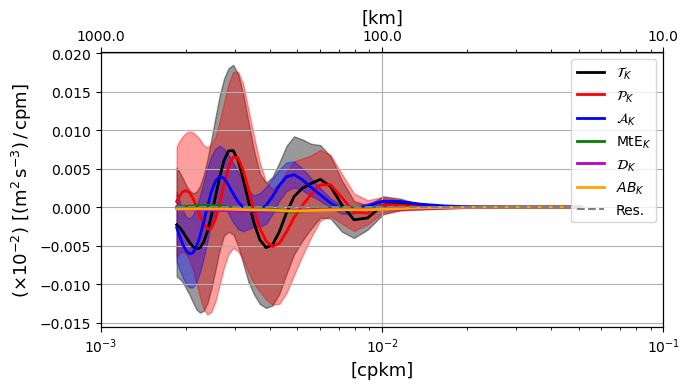

In [76]:
for reg in range(5,6):
    # ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds2 = xr.open_dataset(op.join(savedir,'isoDiags-ext_u_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds3 = xr.open_dataset(op.join(savedir,'isoDiags-ext_v_region%02d_1967-01-01.zarr' 
    #                               % reg))
    
    datas = ((dtau.iso_uT + dtav.iso_vT
              # ds0.iso_uT + ds1.iso_vT
             ).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Tres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    datas = ((ds0.iso_uAB + ds1.iso_vAB).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    ABres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng
                     )
    datas = ((ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE
             ).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Pres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    datas = ((ds2.iso_uD + ds3.iso_vD).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Dres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
        
    
    Tk = (dtau.iso_uT + dtav.iso_vT
          # ds0.iso_uT + ds1.iso_vT
         ).mean(['nmemb']).sum('angle').compute()
    ABk = (ds0.iso_uAB + ds1.iso_vAB).mean(['nmemb']).sum('angle').compute()
    
    Pk = (ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE
         ).mean(['nmemb']).sum('angle').compute()
    Dk = (ds2.iso_uD + ds3.iso_vD).mean(['nmemb']).sum('angle').compute()
    
    # MtE = (ds4.iso_uA + ds4.iso_vA)
    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    
    # datas = (MtE.mean('grid').sum('angle').transpose('nmemb','scale')
    #          * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    # rng = np.random.default_rng()
    # MtEres = bootstrap(datas, np.mean, confidence_level=0.95,
    #                    random_state=rng
    #                   )
    datas = (SP.sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    SPres = bootstrap(datas, np.mean, confidence_level=0.95,
                       random_state=rng
                      )
    datas = ((dtau.iso_uA + dtav.iso_vA
              # ds0.iso_uA + ds1.iso_vA
              # - MtE
              + SP
             ).sum('angle').transpose('nmemb','scale')
             * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Ares = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    
    Ak = (dtau.iso_uA + dtav.iso_vA
          # ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         ).mean(['nmemb']).sum('angle').compute()
    # MtEk = MtE.mean(['nmemb']).sum('angle').compute()
    SPk = SP.mean(['nmemb']).sum('angle').compute()
    
    res = Tk/86400 - (Pk + (dtau.iso_uA + dtav.iso_vA
                            # ds0.iso_uA + ds1.iso_vA
                           ).mean(['nmemb']).sum('angle').compute() 
                      + Dk + ABk
                     )
            
    fig, ax = plt.subplots(figsize=(7,4))
    fig.set_tight_layout(True)
    ax2 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Tres.confidence_interval.low/86400., 
                    Tres.confidence_interval.high/86400., 
                    alpha=.4, color='k')
    ax.fill_between((ds0.scale)**-1*1e3, Pres.confidence_interval.low, 
                    Pres.confidence_interval.high, 
                    alpha=.38, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Ares.confidence_interval.low, 
                    Ares.confidence_interval.high, 
                    alpha=.36, color='b')
    ax.fill_between((ds0.scale)**-1*1e3, -SPres.confidence_interval.high, 
                    -SPres.confidence_interval.low, 
                    alpha=.34, color='g')
    ax.fill_between((ds0.scale)**-1*1e3, Dres.confidence_interval.low, 
                    Dres.confidence_interval.high, 
                    alpha=.32, color='m')
    ax.fill_between((ds0.scale)**-1*1e3, ABres.confidence_interval.low, 
                    ABres.confidence_interval.high, 
                    alpha=.3, color='orange')
    
    ax.plot((ds0.scale)**-1*1e3, Tk*np.diff(ds0.angle)[0]*2*1e2/86400.,
            'k', lw=2, label=r"$\mathcal{T}_K$")
    ax.plot((ds0.scale)**-1*1e3, Pk*np.diff(ds0.angle)[0]*2*1e2,
            'r', lw=2, label=r"$\mathcal{P}_K$")
    ax.plot((ds0.scale)**-1*1e3, Ak*np.diff(ds0.angle)[0]*2*1e2,
            'b', lw=2, label=r"$\mathcal{A}_K$")
    ax.plot((ds0.scale)**-1*1e3, -SPk*np.diff(ds0.angle)[0]*2*1e2,
            'g', lw=2, label=r"MtE$_K$")
    ax.plot((ds0.scale)**-1*1e3, (Dk)*np.diff(ds0.angle)[0]*2*1e2,
            'm', lw=2, label=r"$\mathcal{D}_K$")
    ax.plot((ds0.scale)**-1*1e3, ABk*np.diff(ds0.angle)[0]*2*1e2,
            c='orange', lw=2, label=r"$AB_K$")
    ax.plot((ds0.scale)**-1*1e3, res*np.diff(ds0.angle)[0]*2*1e2, 
            c='grey', ls='--', label=r"Res.")

    ax.set_xscale('log')
    ax2.set_xscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    # Meta = np.abs(Pk.isel(Z=0)).max(skipna=True).values*1e3
    # ax.set_ylim([-Meta*.7, Meta*.7])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-2}$) [(m$^2\,$s$^{-3})\,/\,$cpm]", fontsize=13)
    ax.grid(True)
    # if reg % 5 == 0:
    ax.legend(loc='upper right', fontsize=10)
    plt.savefig(op.join(spec,'Figs/SpecKEbudget_3x3_Region%02d_Z452_%010d.pdf' 
                        % (reg,iiter)))
    plt.show()

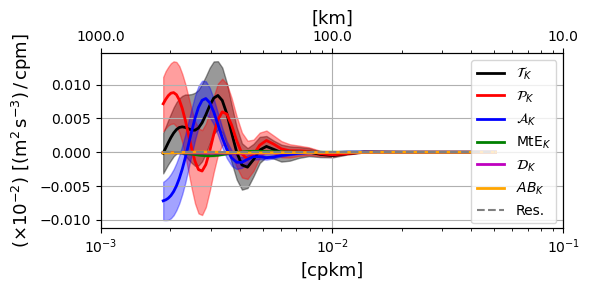

In [27]:
for reg in range(1):
    
    dsw = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr'
                       % reg)
    iso_psUw = dsw.U
    iso_psVw = dsw.V
    dks = xr.DataArray(np.abs(np.diff(dsw.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(dsw.scale[1:].data + dsw.scale[:-1].data)}
                      ).interp(scale=dsw.scale, kwargs={"fill_value":"extrapolate"})
    E = .5*((iso_psUw + iso_psVw) * dks).sum('scale').mean('nmemb')
    iM = np.argmax(E.data)
    im = np.argmin(E.data)
    iangle = im
    # ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds2 = xr.open_dataset(op.join(savedir,'isoDiags-ext_u_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds3 = xr.open_dataset(op.join(savedir,'isoDiags-ext_v_region%02d_1967-01-01.zarr' 
    #                               % reg))
    
    datas = ((ds0.iso_uT + ds1.iso_vT).isel(angle=iangle).transpose('nmemb','scale')
             *2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Tres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    datas = ((ds0.iso_uAB + ds1.iso_vAB).isel(angle=iangle).transpose('nmemb','scale')
             *2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    ABres = bootstrap(datas, np.mean, confidence_level=0.95,
                      random_state=rng
                     )
    datas = ((ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE
             ).isel(angle=iangle).transpose('nmemb','scale')
             *2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Pres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    datas = ((ds2.iso_uD + ds3.iso_vD).isel(angle=iangle).transpose('nmemb','scale')
             *2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Dres = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
        
    
    Tk = (ds0.iso_uT + ds1.iso_vT).mean(['nmemb']).isel(angle=iangle).compute()
    ABk = (ds0.iso_uAB + ds1.iso_vAB).mean(['nmemb']).isel(angle=iangle).compute()
    
    Pk = (ds0.iso_uP + ds1.iso_vP + ds2.iso_uE + ds3.iso_vE
         ).mean(['nmemb']).isel(angle=iangle).compute()
    Dk = (ds2.iso_uD + ds3.iso_vD).mean(['nmemb']).isel(angle=iangle).compute()
    
    # MtE = (ds4.iso_uA + ds4.iso_vA)
    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    
    # datas = (MtE.mean('grid').sum('angle').transpose('nmemb','scale')
    #          * np.diff(ds0.angle)[0]*2*1e2,)  # samples must be in a sequence
    # rng = np.random.default_rng()
    # MtEres = bootstrap(datas, np.mean, confidence_level=0.95,
    #                    random_state=rng
    #                   )
    datas = (SP.isel(angle=iangle).transpose('nmemb','scale')
             *2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    SPres = bootstrap(datas, np.mean, confidence_level=0.95,
                       random_state=rng
                      )
    datas = ((ds0.iso_uA + ds1.iso_vA 
              # - MtE
              + SP
             ).isel(angle=iangle).transpose('nmemb','scale')
             *2*1e2,)  # samples must be in a sequence
    rng = np.random.default_rng()
    Ares = bootstrap(datas, np.mean, confidence_level=0.95,
                     random_state=rng
                    )
    
    Ak = (ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         ).mean(['nmemb']).isel(angle=iangle).compute()
    # MtEk = MtE.mean(['nmemb']).sum('angle').compute()
    SPk = SP.mean(['nmemb']).isel(angle=iangle).compute()
    
    res = Tk/86400 - (Pk + (ds0.iso_uA + ds1.iso_vA
                           ).mean(['nmemb']).isel(angle=iangle).compute() 
                      + Dk + ABk
                     )
            
    fig, ax = plt.subplots(figsize=(6,3))
    fig.set_tight_layout(True)
    ax2 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Tres.confidence_interval.low/86400., 
                    Tres.confidence_interval.high/86400., 
                    alpha=.4, color='k')
    ax.fill_between((ds0.scale)**-1*1e3, Pres.confidence_interval.low, 
                    Pres.confidence_interval.high, 
                    alpha=.38, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Ares.confidence_interval.low, 
                    Ares.confidence_interval.high, 
                    alpha=.36, color='b')
    ax.fill_between((ds0.scale)**-1*1e3, -SPres.confidence_interval.high, 
                    -SPres.confidence_interval.low, 
                    alpha=.34, color='g')
    ax.fill_between((ds0.scale)**-1*1e3, Dres.confidence_interval.low, 
                    Dres.confidence_interval.high, 
                    alpha=.32, color='m')
    ax.fill_between((ds0.scale)**-1*1e3, ABres.confidence_interval.low, 
                    ABres.confidence_interval.high, 
                    alpha=.3, color='orange')
    
    ax.plot((ds0.scale)**-1*1e3, Tk*2*1e2/86400.,
            'k', lw=2, label=r"$\mathcal{T}_K$")
    ax.plot((ds0.scale)**-1*1e3, Pk*2*1e2,
            'r', lw=2, label=r"$\mathcal{P}_K$")
    ax.plot((ds0.scale)**-1*1e3, Ak*2*1e2,
            'b', lw=2, label=r"$\mathcal{A}_K$")
    ax.plot((ds0.scale)**-1*1e3, -SPk*2*1e2,
            'g', lw=2, label=r"MtE$_K$")
    ax.plot((ds0.scale)**-1*1e3, Dk*2*1e2,
            'm', lw=2, label=r"$\mathcal{D}_K$")
    ax.plot((ds0.scale)**-1*1e3, ABk*2*1e2,
            c='orange', lw=2, label=r"$AB_K$")
    ax.plot((ds0.scale)**-1*1e3, res*2*1e2, 
            c='grey', ls='--', label=r"Res.")

    ax.set_xscale('log')
    ax2.set_xscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    # Meta = np.abs(Pk.isel(Z=0)).max(skipna=True).values*1e3
    # ax.set_ylim([-Meta*.7, Meta*.7])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"($\times 10^{-2}$) [(m$^2\,$s$^{-3})\,/\,$cpm]", fontsize=13)
    ax.grid(True)
    # if reg % 5 == 0:
    ax.legend(loc='upper right', fontsize=10)
    plt.savefig(op.join(spec,'Figs/SpecKEbudget_3x3_min_Region%02d_Z452_%010d.pdf' 
                        % (reg,iiter)))
    plt.show()